# Getting Started with chronos-lab

This tutorial introduces the core concepts of chronos-lab.

## What You'll Learn

- Fetching OHLCV data from Yahoo Finance and Intrinio
- Persisting data with ArcticDB for high-performance storage
- Working with datasets for organizing securities metadata
- Storing visualizations and other files

## Setup

Install chronos-lab with all required extras for this tutorial:

In [ ]:
!pip install chronos-lab[yfinance,intrinio,arcticdb,analysis,visualization]

### Understanding Configuration

On first import, chronos-lab automatically creates a configuration file at `~/.chronos_lab/.env`. Let's examine its default settings:

In [1]:
import chronos_lab
!cat ~/.chronos_lab/.env

# Intrinio API Settings
#INTRINIO_API_KEY=

# Datatset Settings
DATASET_LOCAL_PATH=~/.chronos_lab/datasets
#DATASET_DDB_TABLE_NAME=
#DATASET_DDB_MAP='{
#    "ddb_watchlist": {
#        "pk": "map#ibpm#watchlist",
#        "sk": "name"
#    },
#    "ddb_securities_intrinio": {
#        "pk": "map#intrinio#securities"
#    },
#    "ddb_ohlcv_anomalies": {
#        "pk": "chronos_lab#ohlcv_anomalies"
#    }
#}'

# Store Settings
STORE_LOCAL_PATH=~/.chronos_lab/store
#STORE_S3_BUCKET=

# ArcticDB Settings
ARCTICDB_LOCAL_PATH=~/.chronos_lab/arcticdb
ARCTICDB_DEFAULT_LIBRARY_NAME=uscomp
#ARCTICDB_S3_BUCKET=

# Logging
LOG_LEVEL=WARNING

✓ Chronos Lab: Created config at /Users/vitalik/.chronos_lab/.env


Key settings:
- **DATASET_LOCAL_PATH**: Where JSON datasets are stored (securities lists, metadata)
- **STORE_LOCAL_PATH**: Where files (charts, reports) are saved
- **ARCTICDB_LOCAL_PATH**: High-performance time series database location
- **INTRINIO_API_KEY**: Your Intrinio API key (optional, for Intrinio data)

Now let's import the library:

In [1]:
from chronos_lab.sources import ohlcv_from_yfinance, ohlcv_from_arcticdb, from_dataset, ohlcv_from_intrinio, securities_from_intrinio
from chronos_lab.storage import ohlcv_to_arcticdb, to_dataset, to_store
import random

## Working with Yahoo Finance Data

Yahoo Finance provides free access to historical price data for thousands of securities. Let's start with a simple example.

### Fetching OHLCV Data

Download 6 months of daily OHLCV (Open, High, Low, Close, Volume) data for a few tech stocks:

In [2]:
symbols = ["AAPL", "MSFT", "GOOGL", "NVDA", "META", "TSLA", "AMZN"]

ohlcv = ohlcv_from_yfinance(symbols=symbols, period='6mo')

print(f"Downloaded data for {len(ohlcv.index.get_level_values('symbol').unique())} symbols")
print(f"Date range: {ohlcv.index.get_level_values('date').min()} to {ohlcv.index.get_level_values('date').max()}")
ohlcv.head(10)

[*********************100%***********************]  7 of 7 completed


Downloaded data for 7 symbols
Date range: 2025-07-28 00:00:00+00:00 to 2026-01-27 00:00:00+00:00


,,open,high,low,close,volume
date,symbol,,,,,
2025-07-28 00:00:00+00:00,AAPL,213.580334,214.398618,212.612370,213.600296,37858000
2025-07-29 00:00:00+00:00,AAPL,213.730001,214.358682,210.377075,210.826126,51411700
2025-07-30 00:00:00+00:00,AAPL,211.454797,211.943773,207.283587,208.610794,45512500
2025-07-31 00:00:00+00:00,AAPL,208.051976,209.399131,206.724769,207.133911,80698400
2025-08-01 00:00:00+00:00,AAPL,210.426956,213.131269,201.076647,201.954803,104434500
2025-08-04 00:00:00+00:00,AAPL,204.080327,207.443257,201.256270,202.922775,75109300
2025-08-05 00:00:00+00:00,AAPL,202.972655,204.908581,201.735270,202.493668,44155100
2025-08-06 00:00:00+00:00,AAPL,205.197971,214.927486,205.158046,212.801956,108483100
2025-08-07 00:00:00+00:00,AAPL,218.420141,220.386003,216.124970,219.567719,90224800


The returned DataFrame has a MultiIndex `(date, symbol)` with columns for open, high, low, close, and volume. All timestamps are UTC timezone-aware.

### Storing Data to ArcticDB

ArcticDB provides high-performance storage for time series data. Let's persist our downloaded data:

In [3]:
result = ohlcv_to_arcticdb(ohlcv=ohlcv)

if result['statusCode'] == 0:
    print(f"✓ Data was successfully stored to ArcticDB")

✓ Data was successfully stored to ArcticDB


Let's examine where the data is stored locally:

In [4]:
!ls -lh ~/.chronos_lab/arcticdb/

total 0
drwxr-xr-x@ 4 vitalik  staff   128B Jan 27 11:38 _arctic_cfg
drwxr-xr-x@ 4 vitalik  staff   128B Jan 27 11:38 uscomp


ArcticDB uses LMDB for local storage, providing fast read/write operations and automatic compression. "uscomp" is the default library name.

### Reading Data from ArcticDB

Retrieve stored data with optional date range filtering:

In [5]:
# Read all data for specific symbols
ohlcv_df = ohlcv_from_arcticdb(symbols=["AAPL", "MSFT"])

print(f"Retrieved {len(ohlcv_df)} rows")
ohlcv_df.tail(5)

Retrieved 254 rows


,,open,high,low,close,volume
date,symbol,,,,,
2026-01-21 00:00:00+00:00,MSFT,452.600006,452.690002,438.679993,444.109985,37980500
2026-01-22 00:00:00+00:00,MSFT,447.619995,452.839996,444.700012,451.140015,25349400
2026-01-23 00:00:00+00:00,MSFT,451.869995,471.100006,450.529999,465.950012,38000200
2026-01-26 00:00:00+00:00,MSFT,465.309998,474.250000,462.000000,470.279999,29247100
2026-01-27 00:00:00+00:00,MSFT,473.644989,479.799988,473.160004,479.579987,10656873


In [6]:
# Read specific date range
ohlcv_dates_df = ohlcv_from_arcticdb(symbols=['AAPL', 'MSFT'], start_date='2026-01-21', end_date='2026-01-22')

print(f"Retrieved {len(ohlcv_dates_df)} rows")
ohlcv_dates_df.tail(5)

Retrieved 4 rows


,,open,high,low,close,volume
date,symbol,,,,,
2026-01-21 00:00:00+00:00,AAPL,248.699997,251.559998,245.179993,247.649994,54641700
2026-01-22 00:00:00+00:00,AAPL,249.199997,251.000000,248.149994,248.350006,39708300
2026-01-21 00:00:00+00:00,MSFT,452.600006,452.690002,438.679993,444.109985,37980500
2026-01-22 00:00:00+00:00,MSFT,447.619995,452.839996,444.700012,451.140015,25349400


You can also filter by period, limit which columns are returned, and pivot the data for easier analysis:

In [7]:
# Get last 30 days as dictionary format
ohlcv_df_pivoted = ohlcv_from_arcticdb(
    symbols=["NVDA", "TSLA"],
    period="30d",
    columns=["close"],
    pivot=True
)
ohlcv_df_pivoted.tail()

close            
symbol                           NVDA        TSLA
date                                             
2026-01-21 00:00:00+00:00  183.320007  431.440002
2026-01-22 00:00:00+00:00  184.839996  449.359985
2026-01-23 00:00:00+00:00  187.669998  449.059998
2026-01-26 00:00:00+00:00  186.470001  435.200012
2026-01-27 00:00:00+00:00  189.705002  434.470001

## Working with Datasets

Datasets are JSON files that store structured metadata like securities lists, watchlists, or configuration data. They're stored in `~/.chronos_lab/datasets/`.

### Using the Example Dataset

chronos-lab includes an example dataset with 50 major US stocks. Let's explore it:

In [8]:
# Load the example dataset as a DataFrame
example_securities = from_dataset(dataset_name='example')

print(f"Example dataset contains {len(example_securities)} securities")
print(f"\nFirst 10 securities:")
example_securities.head(10)

Example dataset contains 50 securities

First 10 securities:


,weight
AAPL,0.02
MSFT,0.02
AMZN,0.02
GOOGL,0.02
META,0.02
NVDA,0.02
MCD,0.02
JPM,0.02
JNJ,0.02
V,0.02


Let's see where this dataset is stored:

In [9]:
!cat ~/.chronos_lab/datasets/example.json | head -n 20

{
  "AAPL": {"weight": 0.02},
  "MSFT": {"weight": 0.02},
  "AMZN": {"weight": 0.02},
  "GOOGL": {"weight": 0.02},
  "META": {"weight": 0.02},
  "NVDA": {"weight": 0.02},
  "MCD": {"weight": 0.02},
  "JPM": {"weight": 0.02},
  "JNJ": {"weight": 0.02},
  "V": {"weight": 0.02},
  "PG": {"weight": 0.02},
  "XOM": {"weight": 0.02},
  "UNH": {"weight": 0.02},
  "MA": {"weight": 0.02},
  "HD": {"weight": 0.02},
  "LLY": {"weight": 0.02},
  "ABBV": {"weight": 0.02},
  "PFE": {"weight": 0.02},
  "AVGO": {"weight": 0.02},


Datasets are simple JSON files with a key-value structure. The keys become the DataFrame index when loaded.

### Creating custom Datasets

Define watchlists and store them in a Dataset for future use:

In [10]:
# Store custom watchlist
watchlist = {
    'tech_leaders': {
        'symbols': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA'],
        'description': 'Large-cap technology companies',
        'created': '2026-01-27'
    },
    'dividend_stocks': {
        'symbols': ['JNJ', 'PG', 'KO', 'PEP', 'MCD'],
        'description': 'Dividend paying stocks',
        'created': '2026-01-27'
    }
}

result = to_dataset(
    dataset_name='watchlists',
    dataset=watchlist
)

### Using Datasets to Drive Downloads

A common pattern is to maintain a dataset of securities and use it to drive bulk downloads. Let's randomly sample from the example dataset:

In [11]:
# Random sample of 15 symbols
random.seed(42)
sampled_symbols = random.sample(list(example_securities.index), 15)

print(f"Downloading data for: {', '.join(sampled_symbols)}")

# Fetch 3 months of data
sampled_ohlcv = ohlcv_from_yfinance(symbols=sampled_symbols, period='3mo')

# Store to ArcticDB
store_result = ohlcv_to_arcticdb(ohlcv=sampled_ohlcv)
if store_result['statusCode'] == 0:
    print(f"✓ Data was successfully stored to ArcticDB")

[*********************100%***********************]  15 of 15 completed


✓ Data was successfully stored to ArcticDB


## Working with Intrinio

Intrinio provides institutional-grade financial data through a commercial API. This section requires an API key in your `~/.chronos_lab/.env` file.

**Note**: If you don't have an Intrinio API key, you can skip this section or sign up at [intrinio.com](https://intrinio.com).

### Fetching Securities List

Intrinio maintains comprehensive securities databases. Let's fetch a sample of US equities:

In [12]:
# Fetch securities metadata from Intrinio
try:
    securities_df = securities_from_intrinio()
    
    if securities_df is not None and len(securities_df) > 0:
        print(f"Fetched {len(securities_df)} securities from Intrinio")
        print(f"\nFirst 5 securities:")
        for idx, row in securities_df.head(5).iterrows():
            ticker = row.get('ticker', 'N/A')
            name = row.get('name', 'N/A')[:40]
            print(f"  {ticker:6} - {name}")
    else:
        securities_df = None
        print("No securities returned (check API key)")
        
except Exception as e:
    securities_df = None
    print(f"Intrinio API not configured or error occurred: {e}")
    print("Skipping Intrinio examples...")

Fetched 4885 securities from Intrinio

First 5 securities:
  A      - Agilent Technologies Inc.
  AA     - Alcoa Corp
  AAL    - American Airlines Group Inc
  AAME   - Atlantic American Corp.
  AAOI   - Applied Optoelectronics Inc


### Saving Securities as a Dataset

Let's save the securities list as a dataset for future use:

In [13]:
if securities_df is not None:
    # Save to dataset
    result = to_dataset(dataset_name='intrinio_securities', dataset=securities_df.to_dict(orient='index'))
    
    if result['statusCode'] == 0:
        print(f"✓ Dataset was successfully saved")
else:
    print("No securities to save (Intrinio not configured)")

✓ Dataset was successfully saved


Let's examine the saved dataset:

In [14]:
!cat ~/.chronos_lab/datasets/intrinio_securities.json 2>/dev/null | head -n 16 || echo "Dataset not created (Intrinio not configured)"

{
  "sec_NX6GzO": {
    "company_id": "com_NXnP4y",
    "exchange": "NYSE",
    "exchange_mic": "XNYS",
    "stock_exchange_id": "sxg_ozMr9y",
    "name": "Agilent Technologies Inc.",
    "code": "EQS",
    "currency": "USD",
    "ticker": "A",
    "composite_ticker": "A:US",
    "sec_figi": "BBG000C2V541",
    "composite_figi": "BBG000C2V3D6",
    "share_class_figi": "BBG001SCTQY4",
    "primary_listing": true
  },


### Using Securities Dataset for OHLCV Download

Now use the saved dataset to drive OHLCV downloads from Intrinio:

In [16]:
if securities_df is not None:
    # Load our securities dataset
    intrinio_securities = from_dataset(dataset_name='intrinio_securities')
    
    # Sample 10 securities for download
    sample_sec_id = random.sample(list(intrinio_securities.index), min(10, len(intrinio_securities)))
    
    print(f"Downloading OHLCV data from Intrinio for {len(sample_sec_id)} securities...")
    print(f"Security IDs: {', '.join(sample_sec_id)}")
    
    try:
        intrinio_ohlcv_df = ohlcv_from_intrinio(
            symbols=sample_sec_id,
            period='3m'
        )
        
        if intrinio_ohlcv_df is not None and len(intrinio_ohlcv_df) > 0:
            print(f"\n✓ Downloaded {len(intrinio_ohlcv_df)} rows")
            
            # Store to a different library in ArcticDB
            store_result = ohlcv_to_arcticdb(ohlcv=intrinio_ohlcv_df,
                                             library_name='intrinio')
            if store_result['statusCode'] == 0:
                print(f"✓ Stored to ArcticDB")
            
            # Show sample
            print(f"\nSample data:")
            display(intrinio_ohlcv_df.head())
        else:
            print("No data returned from Intrinio")
    except Exception as e:
        print(f"Error fetching from Intrinio: {e}")
else:
    print("Skipping Intrinio OHLCV download (no securities available)")

Security IDs: sec_gNqdJv, sec_gkkVxo, sec_qzEmnz, sec_XWMajy, sec_y3GKvd, sec_g4awwk, sec_XLBN6P, sec_gNQ70y, sec_gProVz, sec_gAAkVO

✓ Downloaded 590 rows
✓ Stored to ArcticDB

Sample data:


,,intraperiod,frequency,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume,factor,split_ratio,dividend,change,percent_change,fifty_two_week_high,fifty_two_week_low,symbol
date,id,,,,,,,,,,,,,,,,,,,,
2025-12-03 00:00:00+00:00,sec_gNqdJv,False,daily,9.8800,9.9900,9.8800,9.8900,29630.0,9.8800,9.9900,9.8800,9.8900,29630.0,1.0,1.0,0.0,NaN,NaN,9.99,9.88,EVOX
2025-12-04 00:00:00+00:00,sec_gNqdJv,False,daily,9.9000,9.9100,9.9000,9.9000,180941.0,9.9000,9.9100,9.9000,9.9000,180941.0,1.0,1.0,0.0,0.01,0.001,9.99,9.88,EVOX
2025-12-05 00:00:00+00:00,sec_gNqdJv,False,daily,9.8999,9.8999,9.8999,9.8999,209.0,9.8999,9.8999,9.8999,9.8999,209.0,1.0,1.0,0.0,0.00,0.000,9.99,9.88,EVOX
2025-12-08 00:00:00+00:00,sec_gNqdJv,False,daily,9.9000,9.9100,9.8900,9.8900,3.0,9.9000,9.9100,9.8900,9.8900,3.0,1.0,1.0,0.0,-0.01,-0.001,9.99,9.88,EVOX
2025-12-10 00:00:00+00:00,sec_gNqdJv,False,daily,9.8900,9.9000,9.8800,9.8800,65787.0,9.8900,9.9000,9.8800,9.8800,65787.0,1.0,1.0,0.0,-0.01,-0.001,9.99,9.88,EVOX


In production environments, independent processes can write datasets to DynamoDB (use `ddb_` prefix), and other processes can read them with `from_dataset()`.

## Visualization and Storage

chronos-lab provides convenient functions to store generated files like charts, reports, or any binary content.

### Creating a Simple Chart

Let's create a basic candlestick-style chart using mplfinance with a Bloomberg-inspired theme:


Chart created for AAPL using mplfinance


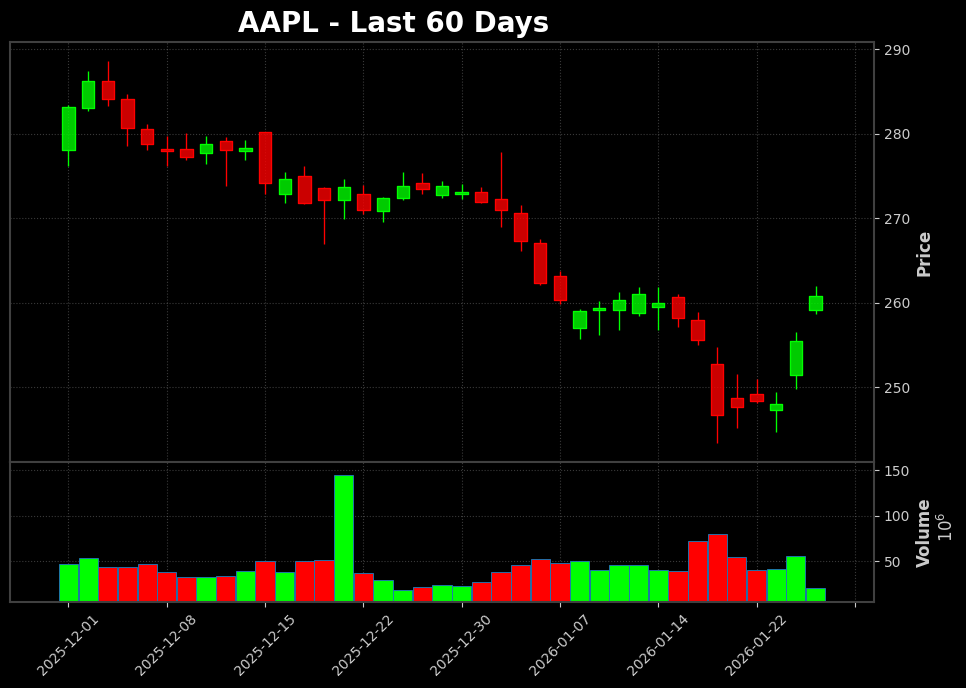

In [19]:
import mplfinance as mpf
from chronos_lab.plot import bloomberg_style
import io

# Get data for a single symbol
symbol = "AAPL"
chart_data = ohlcv_from_arcticdb(symbols=[symbol], period="60d")

if len(chart_data) > 0:
    # Extract symbol data and prepare for mplfinance
    symbol_data = chart_data.xs(symbol, level='symbol')

    # Create the candlestick chart with volume
    fig, axes = mpf.plot(
        symbol_data,
        type='candle',
        style=bloomberg_style,
        volume=True,
        figsize=(12, 8),
        panel_ratios=(3, 1),
        returnfig=True,
        ylabel='Price',
        ylabel_lower='Volume',
        datetime_format='%Y-%m-%d'
    )

    # Adjust styling
    for ax in axes:
        ax.set_facecolor('#000000')
        ax.grid(True, which='major', linestyle=':', linewidth=0.8, color='#C0C0C0')

    fig.suptitle(
        f"{symbol} - Last 60 Days",
        color='white',
        fontsize=20,
        y=0.92
    )

    print(f"\nChart created for {symbol} using mplfinance")
else:
    print(f"No data available for {symbol}")

### Storing the Chart

Save the chart to local storage using `to_store()`:

In [20]:
if len(chart_data) > 0:
    # Save figure to bytes buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    buf.seek(0)
    chart_bytes = buf.read()
    buf.close()
    
    # Store using to_store()
    store_result = to_store(
        file_name=f"{symbol}_chart.png",
        content=chart_bytes,
        folder="charts"
    )
    
    if store_result.get('local_statusCode') == 0:
        print(f"✓ Chart saved to: {store_result['file_path']}")
        print(f"\nStorage directory contents:")
        !ls -lh ~/.chronos_lab/store/charts/

✓ Chart saved to: /Users/vitalik/.chronos_lab/store/charts/AAPL_chart.png

Storage directory contents:
total 136
-rw-r--r--@ 1 vitalik  staff    65K Jan 27 11:48 AAPL_chart.png


Let's verify we can read the saved chart:

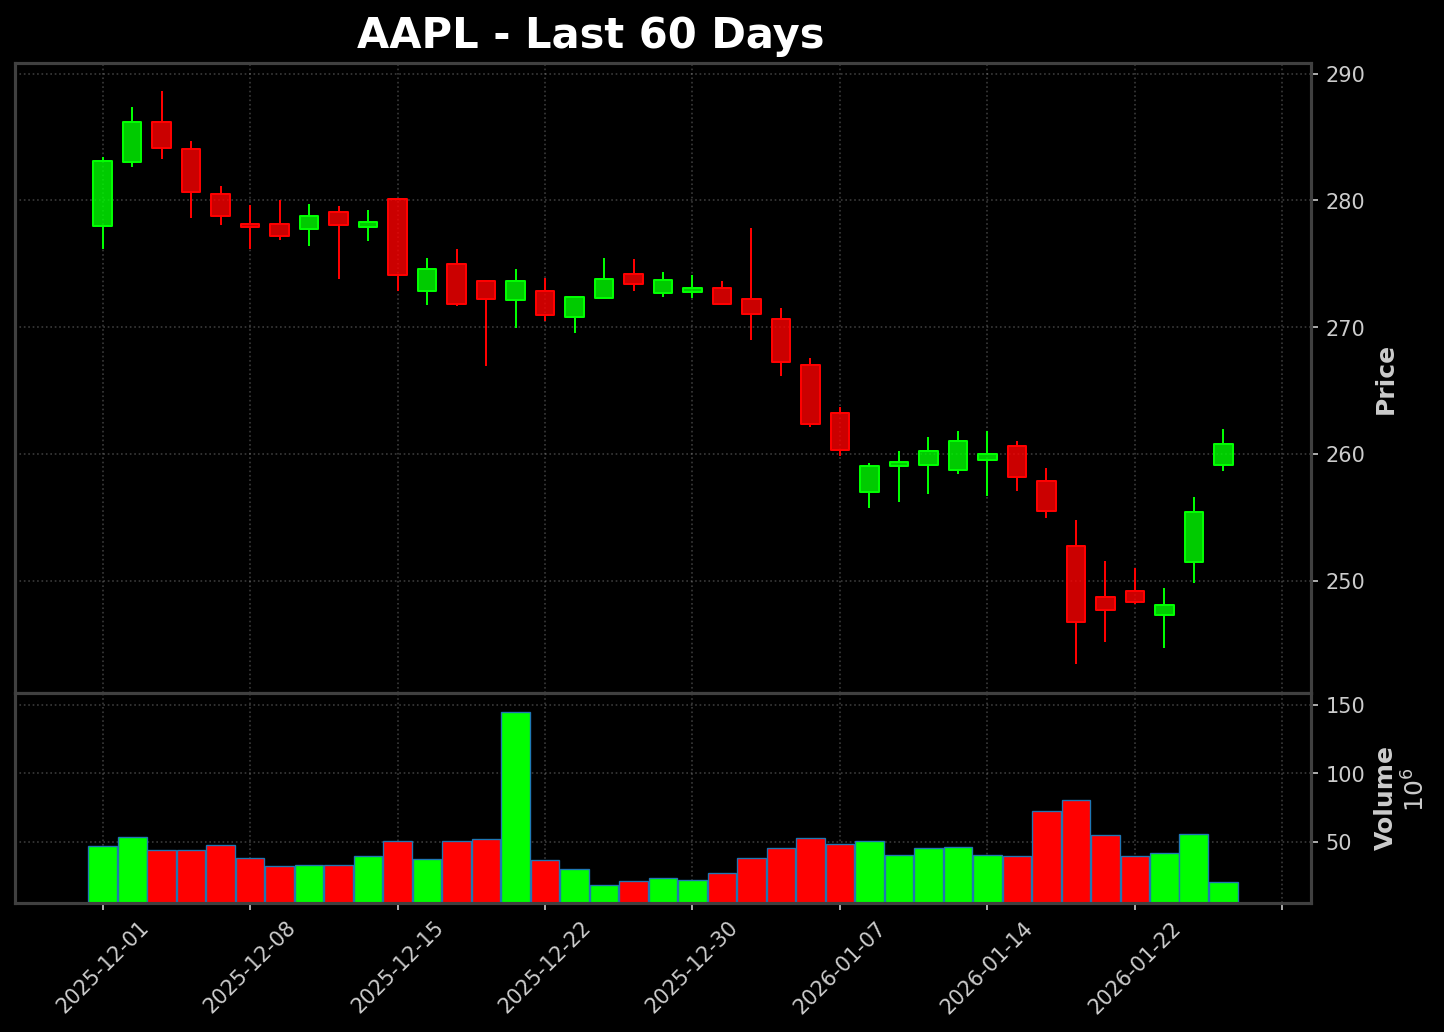


Successfully loaded chart from storage!


In [21]:
if len(chart_data) > 0 and store_result.get('local_statusCode') == 0:
    from IPython.display import Image, display
    
    display(Image(filename=store_result['file_path']))
    print(f"\nSuccessfully loaded chart from storage!")

## Next Steps

You've learned the fundamentals of chronos-lab! Here's what to explore next:

### Advanced Tutorials
- **[OHLCV Anomaly Detection](/chronos-lab/tutorials/ohlcv-anomaly-detection)**: Detect unusual patterns in price data using machine learning

### Key Concepts Recap

1. **Data Flow**: `Fetch → Store → Retrieve`
   - Use `ohlcv_from_*()` to fetch data
   - Use `ohlcv_to_arcticdb()` to store
   - Use `ohlcv_from_arcticdb()` to retrieve

2. **Datasets**: Organize securities metadata
   - Use `from_dataset()` to read
   - Use `to_dataset()` to write
   - Stored as JSON in `~/.chronos_lab/datasets/`

3. **Storage**: Persist any file type
   - Use `to_store()` for charts, reports, etc.
   - Stored in `~/.chronos_lab/store/`